## imports 

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Activation,BatchNormalization,Conv1D,MaxPooling1D,Flatten
from sklearn.metrics import mean_squared_error


### Load Dataset
##### the following dataset contains Iran stock index price since **2014(1393)** to **2019(1397)**

In [61]:
# df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393-1397.csv")
df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393--1403.csv")
df

,name,dateissue,Value
0,????,14021228,2195092.3
1,????,14021227,2160406.5
2,????,14021226,2148494.0
3,????,14021223,2150035.3
4,????,14021222,2163501.0
...,...,...,...
2408,????,13930111,78741.3
2409,????,13930110,78469.2
2410,????,13930109,78239.7
2411,????,13930106,78619.4


In [62]:
df = df.iloc[::-1] 
df

,name,dateissue,Value
2412,????,13930105,79013.5
2411,????,13930106,78619.4
2410,????,13930109,78239.7
2409,????,13930110,78469.2
2408,????,13930111,78741.3
...,...,...,...
4,????,14021222,2163501.0
3,????,14021223,2150035.3
2,????,14021226,2148494.0
1,????,14021227,2160406.5


In [63]:
df = df[["dateissue" , "Value"]] # delete شاخص column

In [64]:
color_pal = sns.color_palette()

In [65]:
df1 = df[df["dateissue"] > 13970211] #barjam date
df2 = df[df["dateissue"] <= 13970211]
df2

,dateissue,Value
2412,13930105,79013.5
2411,13930106,78619.4
2410,13930109,78239.7
2409,13930110,78469.2
2408,13930111,78741.3
...,...,...
1423,13970205,94796.1
1422,13970208,94284.4
1421,13970209,93805.5
1420,13970210,93586.9


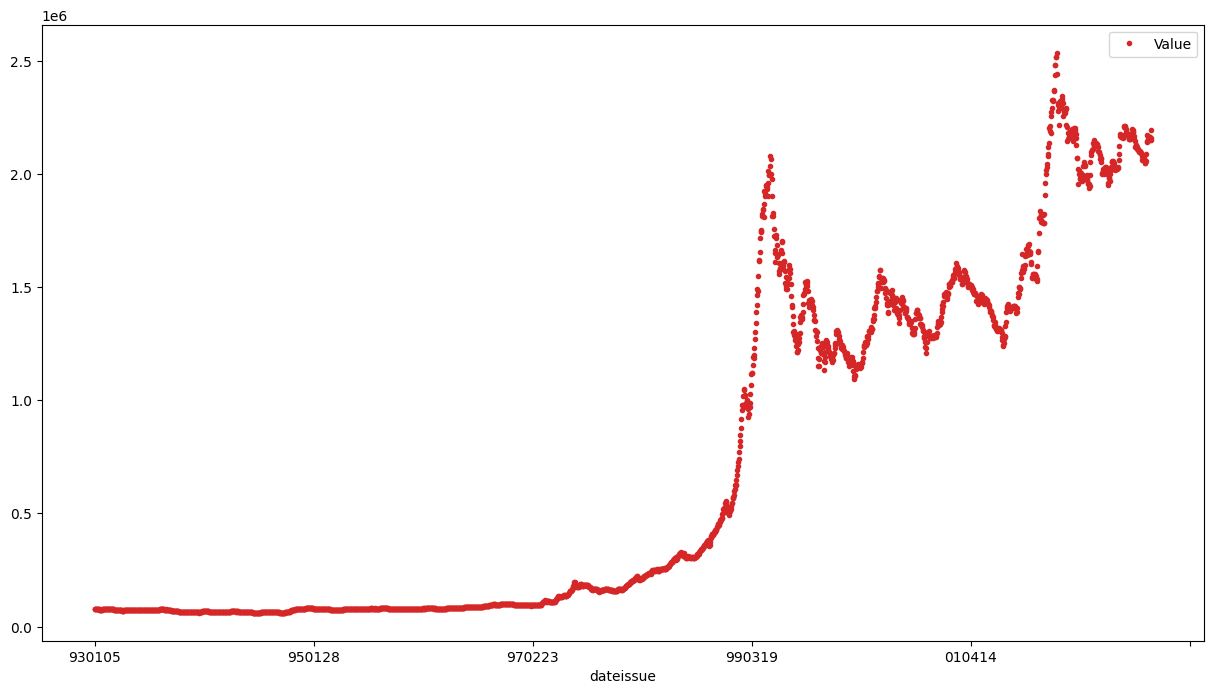

In [66]:
df['dateissue'] = df['dateissue'].apply(lambda x: str(x)[-6:])
df.plot( x="dateissue", y="Value", style='.', figsize=(15,8), color=color_pal[3])
clear_output()
plt.show()

In [67]:
df1['dateissue'] = df1['dateissue'].apply(lambda x: str(x)[-6:])
df2['dateissue'] = df2['dateissue'].apply(lambda x: str(x)[-6:])
clear_output()

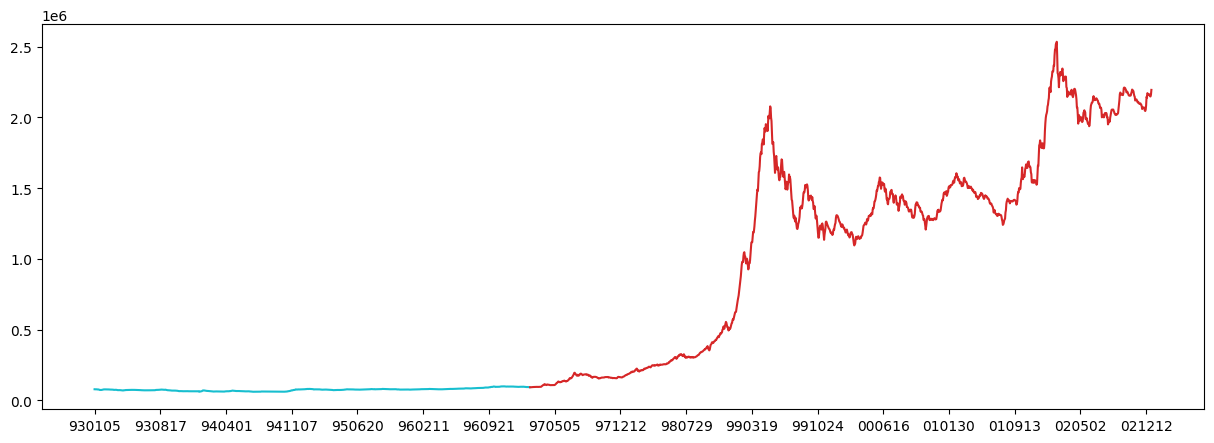

In [68]:
plt.plot(df2["dateissue"], df2["Value"], color=color_pal[9])
plt.plot(df1["dateissue"], df1["Value"], color=color_pal[3]) # after barjam (red)
plt.xticks(np.arange(0, len(df), step=150))
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [69]:
df.shape

(2413, 2)

In [70]:
df.index = df.pop("dateissue")
df

,Value
dateissue,
930105,79013.5
930106,78619.4
930109,78239.7
930110,78469.2
930111,78741.3
...,...
021222,2163501.0
021223,2150035.3
021226,2148494.0


### preprocessing

In [71]:
# scaler = MinMaxScaler(feature_range=(0,1))
# dataset = scaler.fit_transform(dataset)
# dataset

# test_dataset = [i for i in dataset if i not in train_dataset]
# test_dataset

# df['Value'] = df['Value'] / 100000

df_mean = df['Value'].mean()
df['Value'] = df['Value'] / df_mean
clear_output()
df

,Value
dateissue,
930105,0.112551
930106,0.111990
930109,0.111449
930110,0.111776
930111,0.112163
...,...
021222,3.081804
021223,3.062623
021226,3.060427


In [72]:
dataset = df.values

### split train and test datasets  

In [73]:
train_count = math.ceil(len(dataset) * 0.80) # find 80% of our dataset
print(train_count)
print(len(dataset)-train_count)
print(dataset.shape)

1931
482
(2413, 1)


In [74]:
train_dataset = dataset[0:train_count]
train_dataset = np.array(train_dataset)
train_dataset

array([[0.11255096],
       [0.11198958],
       [0.11144872],
       ...,
       [1.90217997],
       [1.90132601],
       [1.90481065]])

##### *we create a sequence(to make an iteratin on the dataset) for every data in the dataframe to use it for lstm and rnn  models in the future.*

In [75]:
x_train = []
y_train = []

for i in range(10,train_count):
    x_train.append(train_dataset[i-10:i, 0])
    y_train.append(train_dataset[i,0])
    if i<=10 : #we can get the first round of the train dataset which we created
        print(x_train)
        print(y_train)

[array([0.11255096, 0.11198958, 0.11144872, 0.11177563, 0.11216323,
       0.11188745, 0.11058693, 0.1102791 , 0.11084732, 0.11028665])]
[0.10897316436782095]


In [76]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1921, 10)

In [77]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1921, 10, 1)

### create models: 
1. LSTM
2. CNN

In [78]:
lstm_model = Sequential()
nn_model = Sequential()

In [79]:
# model = Sequential([
#     layers.LSTM(50, return_sequences=True, input_shape=(10,1)),
#     layers.LSTM(50, return_sequences=False),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(16, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(1, activation='relu'),
# ])

lstm_model.add(LSTM(50, input_shape = (10,1), return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
# lstm_model.add(Activation("linear"))

# model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(8))
# model.add(Dense(1))

In [80]:
nn_model.add(Dense(128,input_shape=(10,1)))
nn_model.add(Conv1D(filters = 112, kernel_size= 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=2, padding='valid'))
nn_model.add(Conv1D(filters = 64,kernel_size = 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=1, padding='valid'))
nn_model.add(Dropout(0.2))
nn_model.add(Flatten())
nn_model.add(Dense(100, activation="linear"))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1))

In [81]:
keras.utils.plot_model(lstm_model) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
lstm_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])
nn_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])

In [83]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               314368    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [84]:
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10, 128)           256       
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 112)           14448     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 112)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 64)             7232      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 64)            

### fit models

In [85]:
lstm_history = lstm_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10


193/193 [==============================] - 8s 16ms/step - loss: 0.0307 - mae: 0.0772 - accuracy: 0.0000e+00
Epoch 2/10
193/193 [==============================] - 3s 15ms/step - loss: 0.0080 - mae: 0.0445 - accuracy: 0.0000e+00
Epoch 3/10
193/193 [==============================] - 3s 14ms/step - loss: 0.0095 - mae: 0.0508 - accuracy: 0.0000e+00
Epoch 4/10
193/193 [==============================] - 3s 14ms/step - loss: 0.0085 - mae: 0.0470 - accuracy: 0.0000e+00
Epoch 5/10
193/193 [==============================] - 3s 15ms/step - loss: 0.0087 - mae: 0.0477 - accuracy: 0.0000e+00
Epoch 6/10
193/193 [==============================] - 3s 14ms/step - loss: 0.0067 - mae: 0.0418 - accuracy: 0.0000e+00
Epoch 7/10
193/193 [==============================] - 3s 14ms/step - loss: 0.0059 - mae: 0.0395 - accuracy: 0.0000e+00
Epoch 8/10
193/193 [==============================] - 3s 16ms/step - loss: 0.0056 - mae: 0.0377 - accuracy: 0.0000e+00
Epoch 9/10
193/193 [==============================] - 3s 14

In [86]:
nn_history = nn_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
193/193 [==============================] - 2s 3ms/step - loss: 0.0337 - mae: 0.0918 - accuracy: 0.0000e+00
Epoch 2/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0126 - mae: 0.0585 - accuracy: 0.0000e+00
Epoch 3/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0129 - mae: 0.0615 - accuracy: 0.0000e+00
Epoch 4/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0128 - mae: 0.0609 - accuracy: 0.0000e+00
Epoch 5/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0136 - mae: 0.0650 - accuracy: 0.0000e+00
Epoch 6/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0122 - mae: 0.0619 - accuracy: 0.0000e+00
Epoch 7/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0107 - mae: 0.0592 - accuracy: 0.0000e+00
Epoch 8/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0141 - mae: 0.0672 - accuracy: 0.0000e+00
Epoch 9/10
193/193 [==============================] - 1s

### create test array

In [87]:
test_dataset = dataset[train_count-10:,:]
x_test = []
y_test = dataset[train_count:,:]

for i in range(10,len(test_dataset)):
    x_test.append(test_dataset[i-10:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))
x_test.shape

(482, 10, 1)

In [88]:
lstm_predicts = lstm_model.predict(x_test)
print(f"lstm shape = {lstm_predicts.shape}")

nn_predicts = nn_model.predict(x_test)
print(f"cnn shape = {lstm_predicts.shape}")

16/16 [==============================] - 1s 9ms/step
lstm shape = (482, 1)
16/16 [==============================] - 0s 1ms/step
cnn shape = (482, 1)


In [89]:
print(nn_history.history.keys())
print(lstm_history.history.keys())

dict_keys(['loss', 'mae', 'accuracy'])
dict_keys(['loss', 'mae', 'accuracy'])


### Model Validation

In [90]:
print(f"Lstm model Last ephoc loss  = {lstm_history.history['loss'][-1]}")
print(f"CNN model Last ephoc loss  = {nn_history.history['loss'][-1]}")

Lstm model Last ephoc loss  = 0.006139575969427824
CNN model Last ephoc loss  = 0.009485745802521706


In [91]:
lstm_test_loss, lstm_test_acc, _ = lstm_model.evaluate(x_test, y_test) 

16/16 [==============================] - 1s 9ms/step - loss: 0.0372 - mae: 0.1517 - accuracy: 0.0000e+00


In [92]:
cnn_test_loss, cnn_test_acc, _ = nn_model.evaluate(x_test, y_test) 

16/16 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.2156 - accuracy: 0.0000e+00


In [93]:
data = {'LSTM': [lstm_test_acc,math.sqrt(mean_squared_error(y_test, lstm_predicts)),mean_squared_error(y_test, lstm_predicts)],
        'CNN': [cnn_test_acc, math.sqrt(mean_squared_error(y_test, nn_predicts)),mean_squared_error(y_test, nn_predicts)]}
errors = pd.DataFrame(data, index=['acc',
                               'RSME',
                               'MSE'])
errors

,LSTM,CNN
acc,0.151672,0.215577
RSME,0.192976,0.233963
MSE,0.037240,0.054739


In [94]:
train = df[:train_count] * df_mean
validation = df[train_count:] * df_mean
validation[['predictions(lstm)']] = lstm_predicts * df_mean
validation[['predictions(nn)']] = nn_predicts * df_mean
clear_output()
validation

,Value,predictions(lstm),predictions(nn)
dateissue,,,
001225,1345018.2,1330661.250,1250804.500
001228,1367250.3,1332771.500,1254730.500
010106,1390859.7,1337175.250,1260920.500
010107,1403617.9,1344670.500,1269134.375
010108,1418651.9,1354091.250,1277060.875
...,...,...,...
021222,2163501.0,1976914.500,1956113.500
021223,2150035.3,1980608.625,1958581.625
021226,2148494.0,1981602.375,1964048.125


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


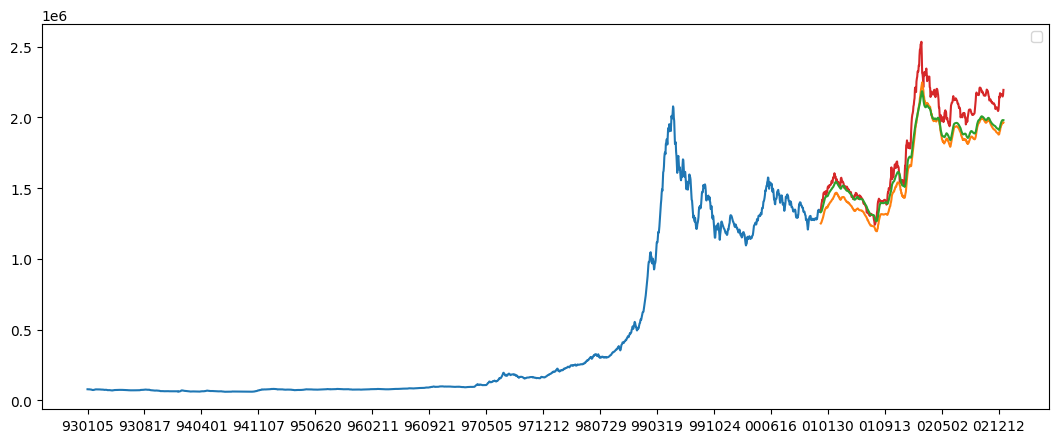

In [97]:
plt.figure(figsize=(12,5))
plt.plot(train["Value"], color=color_pal[0])
plt.plot(validation[["Value"]], color =color_pal[3])
plt.plot(validation[["predictions(nn)"]], color=color_pal[1])
plt.plot(validation[["predictions(lstm)"]], color=color_pal[2])
plt.xticks(np.arange(0, len(df), step=150))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(13, 5)
plt.savefig('models-validation-(93-03)')
plt.show()

# blue = training 
# red = original validation
# orange = predictions using CNN
# green = predictions using LSTM